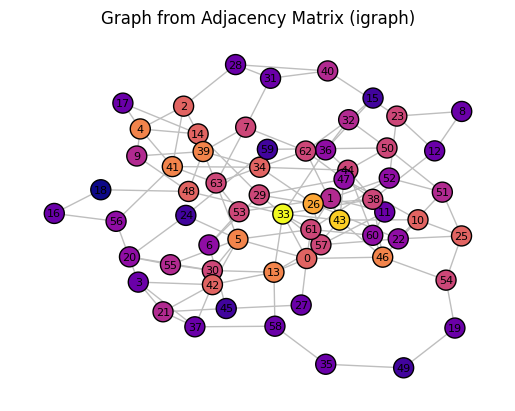

In [1]:
import numpy as np

from framework.SMS import import_dataset_fromSMS, plot_graph_from_adjacency_matrix

datasetSMS = import_dataset_fromSMS("data/SMS/")

sim = list(datasetSMS.keys())[10]
mat = datasetSMS[sim]['adjacency_matrix']
num_nodes = mat.shape[0]
p_vectors_array = datasetSMS[sim]['p_array']
dimP = p_vectors_array.shape[1]


plot_graph_from_adjacency_matrix(mat, node_color_scalars=np.sum(p_vectors_array, axis=1), cmap='plasma')


In [2]:
from framework.trainFct import *
from torch_geometric.data import Data, DataLoader
from framework.visuals import *

latent_dim = 2
input_dim = dimP
batch_size = 16

encoder_hidden_dims=[128, 64, 32]
adj_decoder_hidden_dims=[64, 64, 32]
node_decoder_hidden_dims=[64, 64, 32]
gcn_layers=3
fc_layers=2

dataset = []
for x in datasetSMS.values():
    # Create PyG data object
    data = Data(x=torch.tensor(x["p_array"], dtype=torch.float), 
                edge_index=adj_matrix_to_edge_index(x["adjacency_matrix"])[0], 
                edge_labels=adj_matrix_to_edge_index(x["adjacency_matrix"])[1],
                adjacency_matrix=torch.tensor(x["adjacency_matrix"]))
    dataset.append(data)

# Select a single graph to train on
single_graph = dataset[0]

# Wrap in list for compatibility with DataLoader-like expectations
single_graph_list = [single_graph]


/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:128: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalINS6_17basic_string_viewIcNS6_11char_traitsIcEEEEEE
  Referenced from: <2BF76774-0954-3F15-B7FE-8A5E5111D7DF> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:166: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/

/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


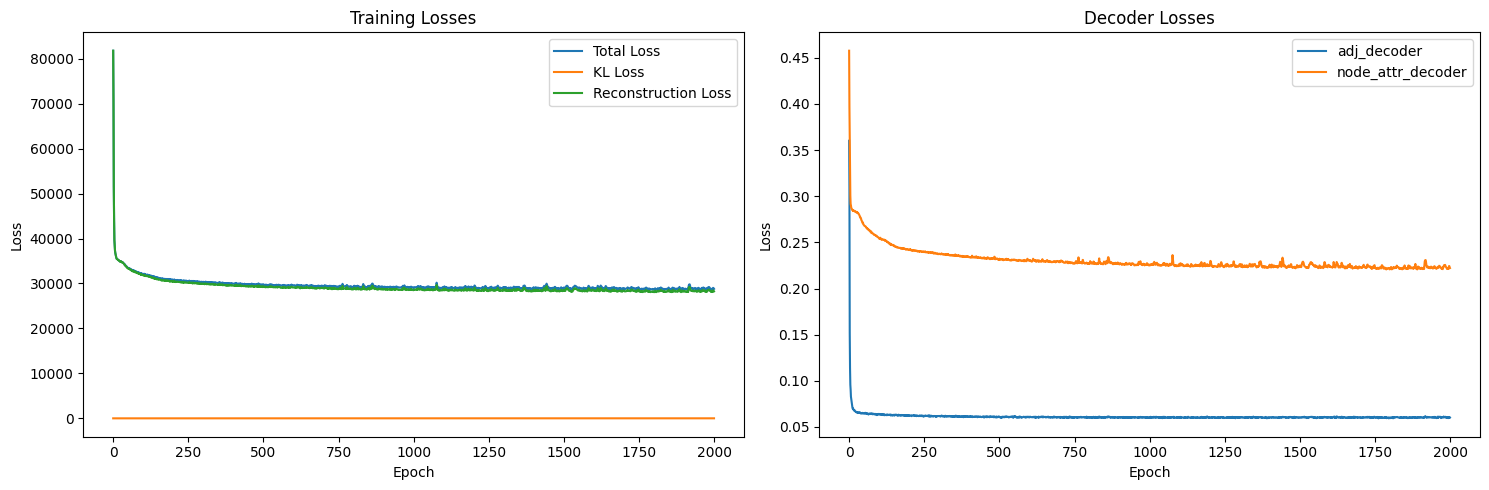

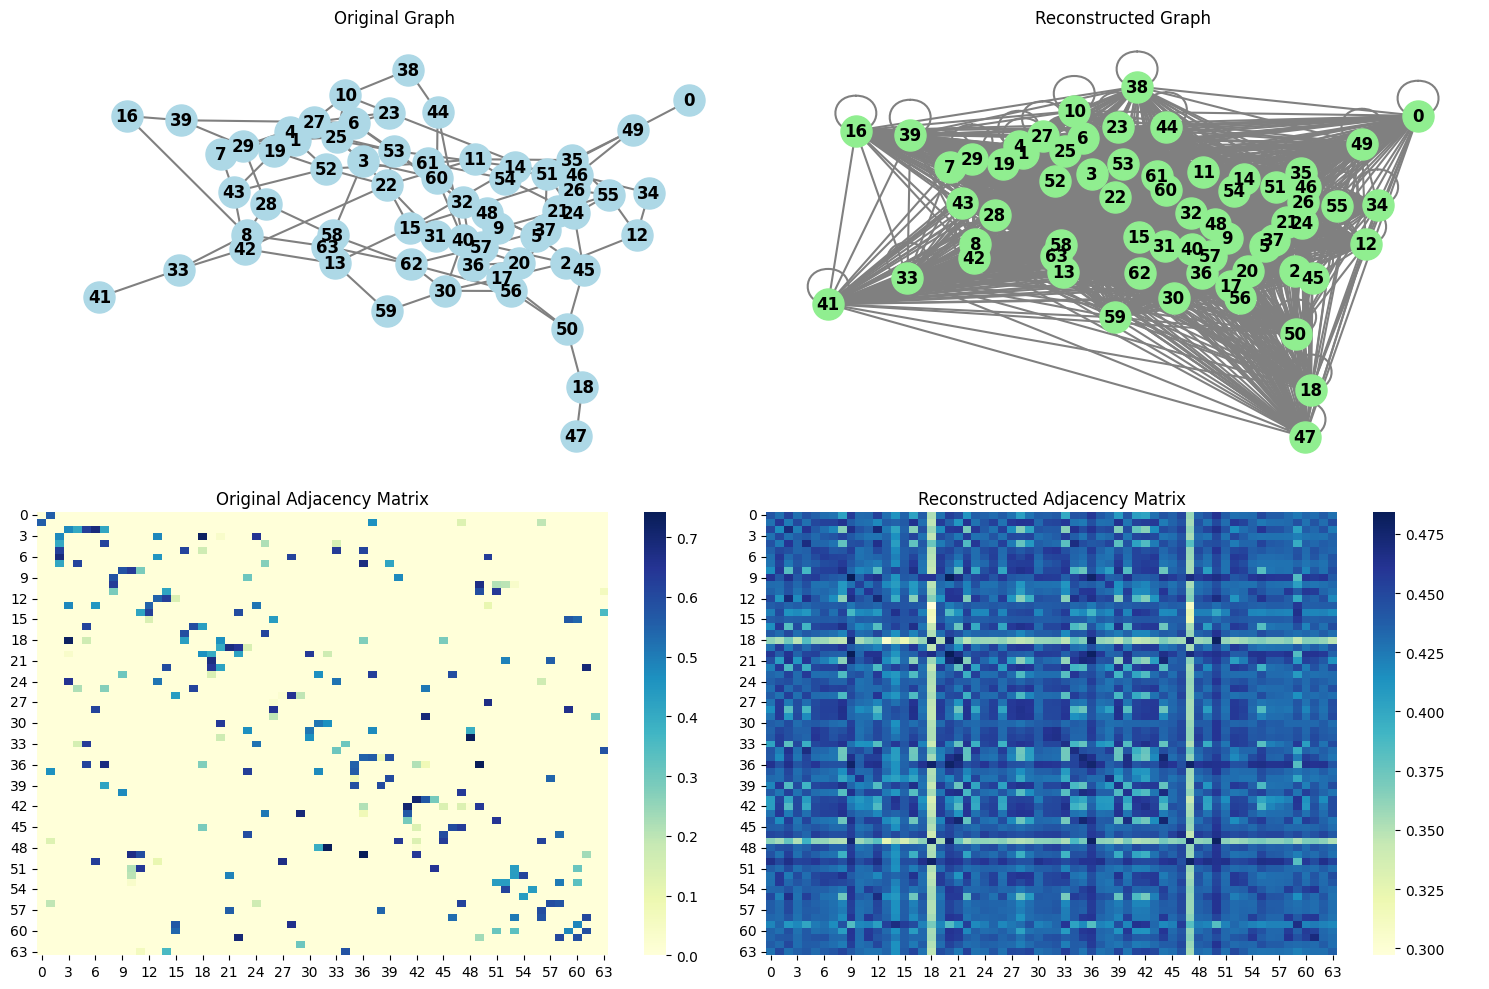

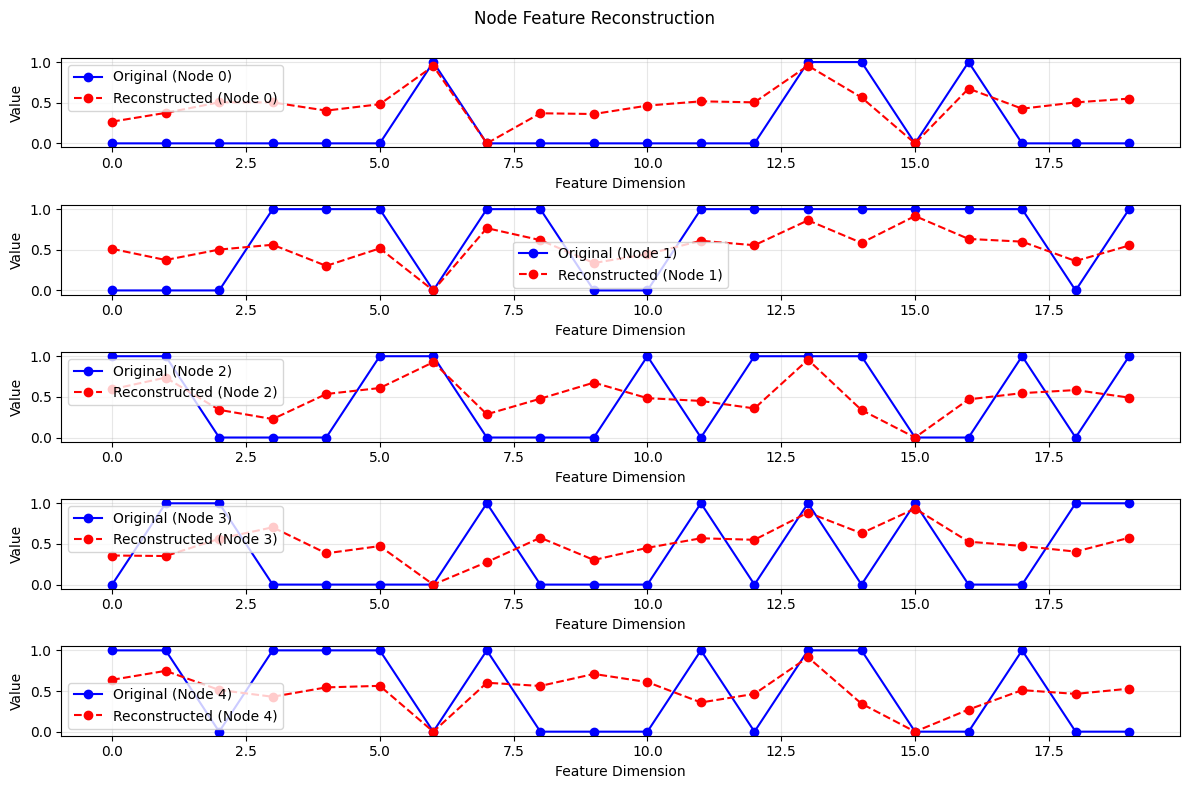

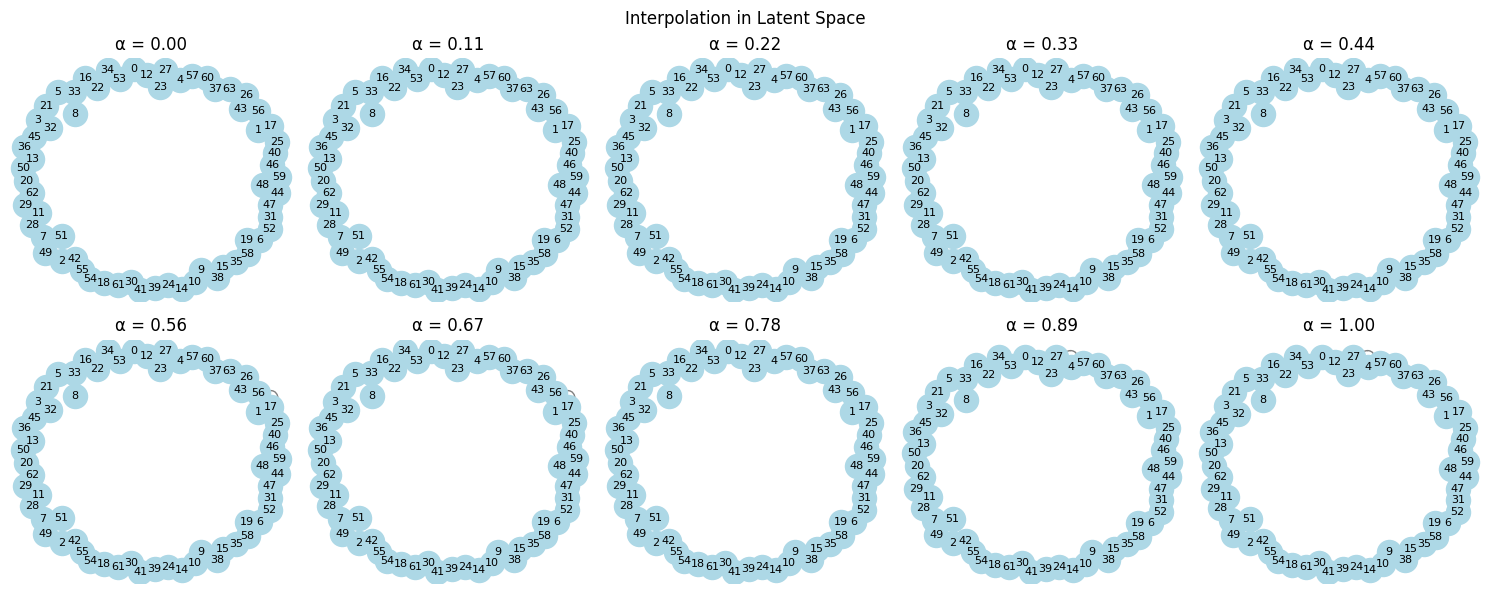

In [ ]:
# Create data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = create_graphvae_model(
    input_dim=input_dim,
    latent_dim=latent_dim,
    encoder_hidden_dims=encoder_hidden_dims,
    adj_decoder_hidden_dims=adj_decoder_hidden_dims,
    node_decoder_hidden_dims=node_decoder_hidden_dims,
    gcn_layers=gcn_layers,
    fc_layers=fc_layers,
    kl_annealing=True,
    anneal_steps=1000,
    anneal_end=100
)

history = train_model(
    model=model,
    data_loader=data_loader,
    num_epochs=1000,
    lr=0.001,
    verbose=False,
    decoder_weights={"adj_decoder": 100000, "node_attr_decoder":100000}
)

visualize_training(history)
visualize_graph_reconstruction(model, dataset[0])
visualize_node_features_reconstruction(model, dataset[0])
interpolate_in_latent_space(model, dataset[0], dataset[5])

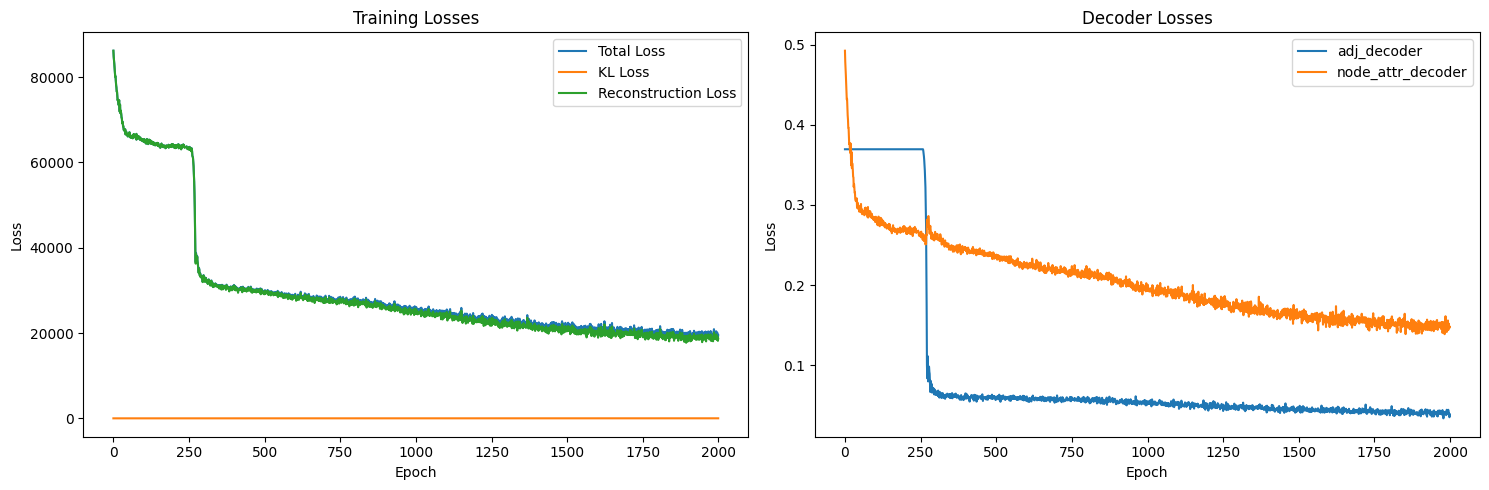

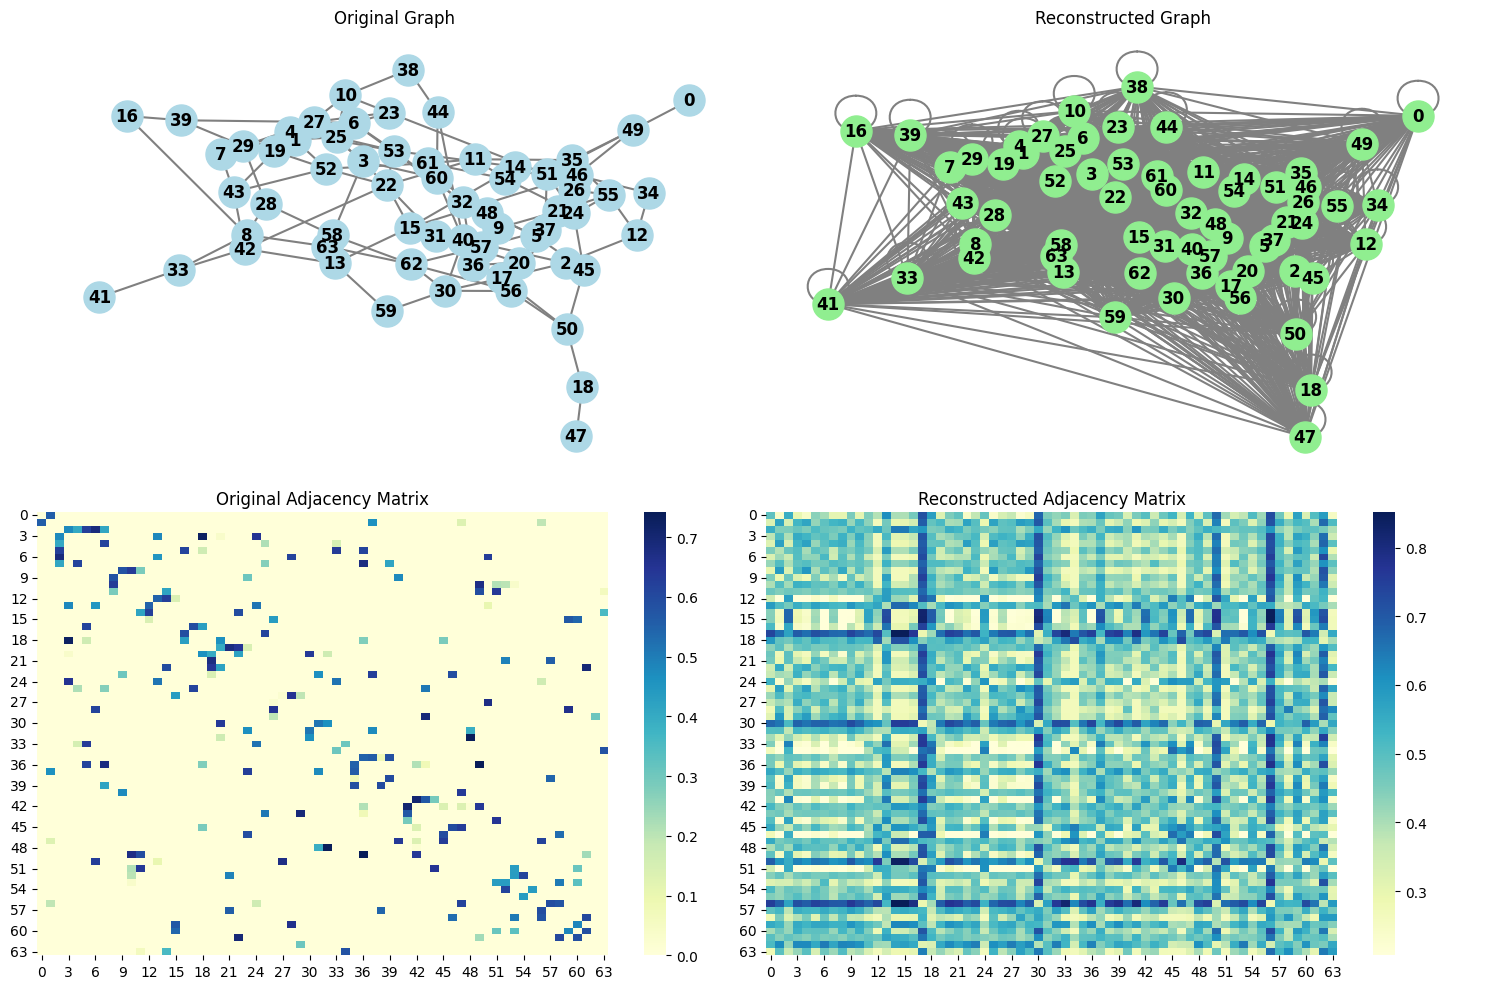

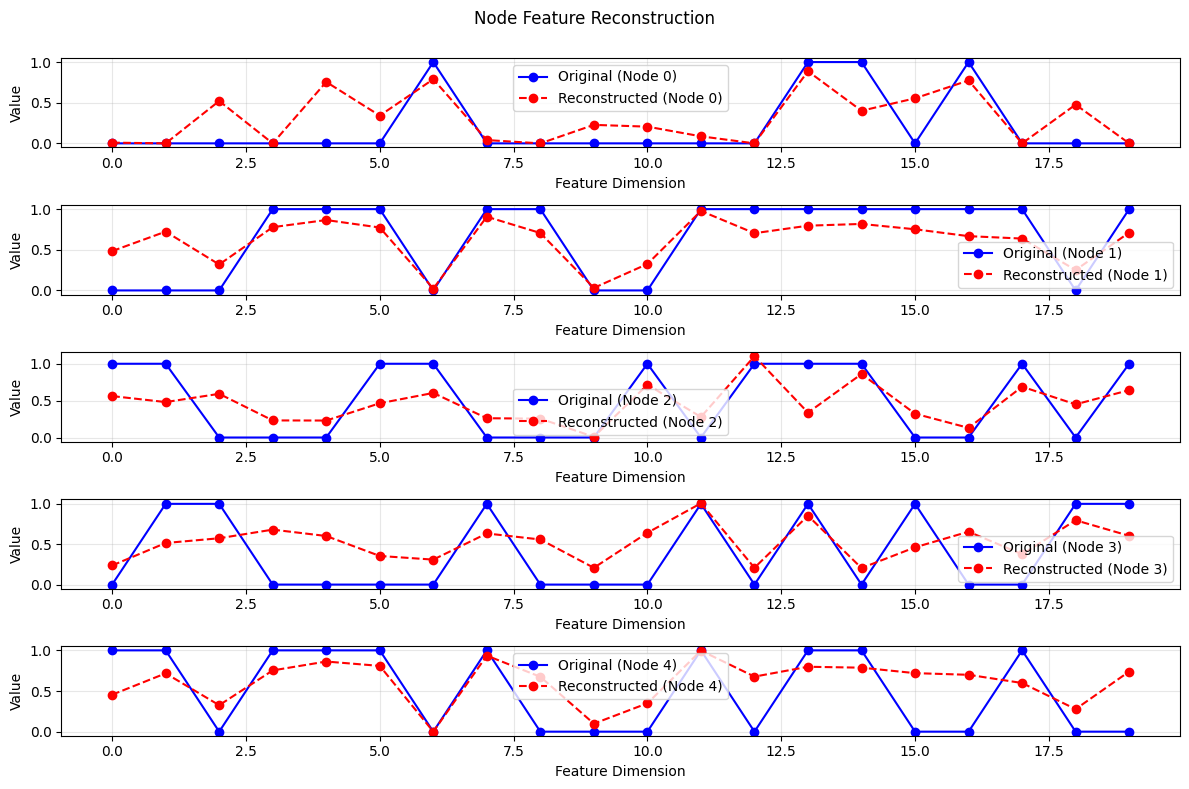

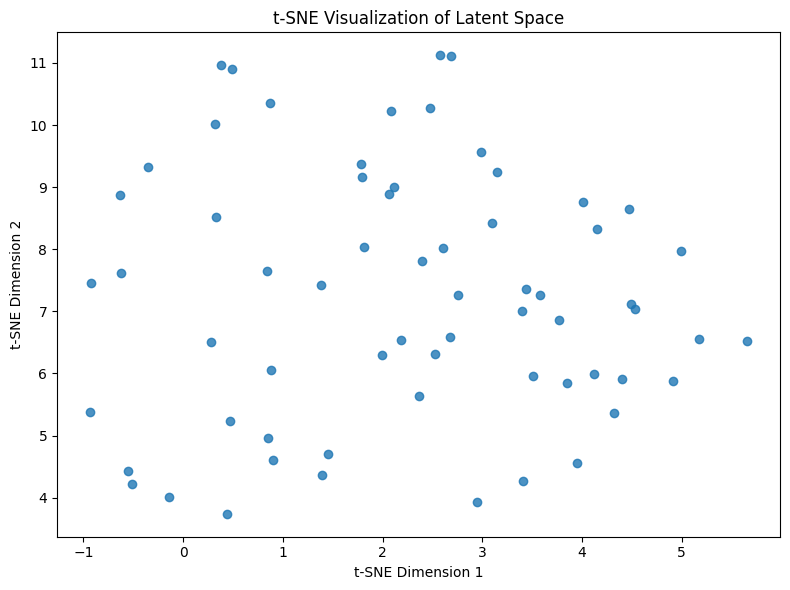

In [ ]:
model = create_graphvae_model(
    input_dim=input_dim,
    latent_dim=latent_dim,
    encoder_hidden_dims=encoder_hidden_dims,
    adj_decoder_hidden_dims=adj_decoder_hidden_dims,
    node_decoder_hidden_dims=node_decoder_hidden_dims,
    gcn_layers=gcn_layers,
    fc_layers=fc_layers,
    kl_annealing=True,
    anneal_steps=1000,
    anneal_end=100
)

history = train_model(
    model=model,
    data_loader=single_graph_list,
    num_epochs=2000,
    lr=0.001,
    verbose=False,
    decoder_weights={"adj_decoder": 100000, "node_attr_decoder":100000}
)

# Visualizations
visualize_training(history)
visualize_graph_reconstruction(model, single_graph)
visualize_node_features_reconstruction(model, single_graph, sample_features=dimP)
visualize_latent_space(model, [single_graph])



In [92]:
from utils.manifolds.visuals import *
from utils.manifolds.core import *

def plot_curvature(model_phase1, single_graph):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_phase1.eval()

    with torch.no_grad():
        x = single_graph.x.to(device)
        edge_index = single_graph.edge_index.to(device)
        latent_mu = model_phase1.encode(x, edge_index)
        recon = model_phase1.forward(x,edge_index)

    def local_decoder_point_metric(z):
        """
        Wrapper to compute the Riemannian metric from the jacobian matrix
        z: numpy array with shape (n,)
        
        Returns an (n x n) metric tensor.
        """
        G = None
        try:
            J = model_phase1.compute_jacobian(torch.unsqueeze(torch.tensor(z, dtype=torch.float),0), "node_attr_decoder", 0)
            G = np.matmul(J.T, J)
                
        except Exception as e:
            print(f"Error at grid point ({z}): {e}")
        return G.numpy()

    #n_dimensions = 2
    #data = latent_mu.numpy()[:10,:]
    #print("Computing distance matrix...")
    #dist = create_riemannian_distance_matrix(data, metric)
    #print("Visualizing...")
    #visualize_manifold_embedding(data,dist )

    curvature, Z1, Z2 = visualize_manifold_curvature(local_decoder_point_metric, data_points=latent_mu[0].numpy(), z_range=(-1.5,1.5))
    #start_point = np.array([-0.5, -0.5])
    #end_point = np.array([0.5, 0.5])
    #plot_geodesics(local_decoder_point_metric, start_point, end_point, curvature, Z1, Z2)
    #plot_geodesic_grid(local_decoder_point_metric, curvature, Z1, Z2)

=== Starting Phase 1: Training encoder with node feature reconstruction ===

=== Phase 1 Complete ===


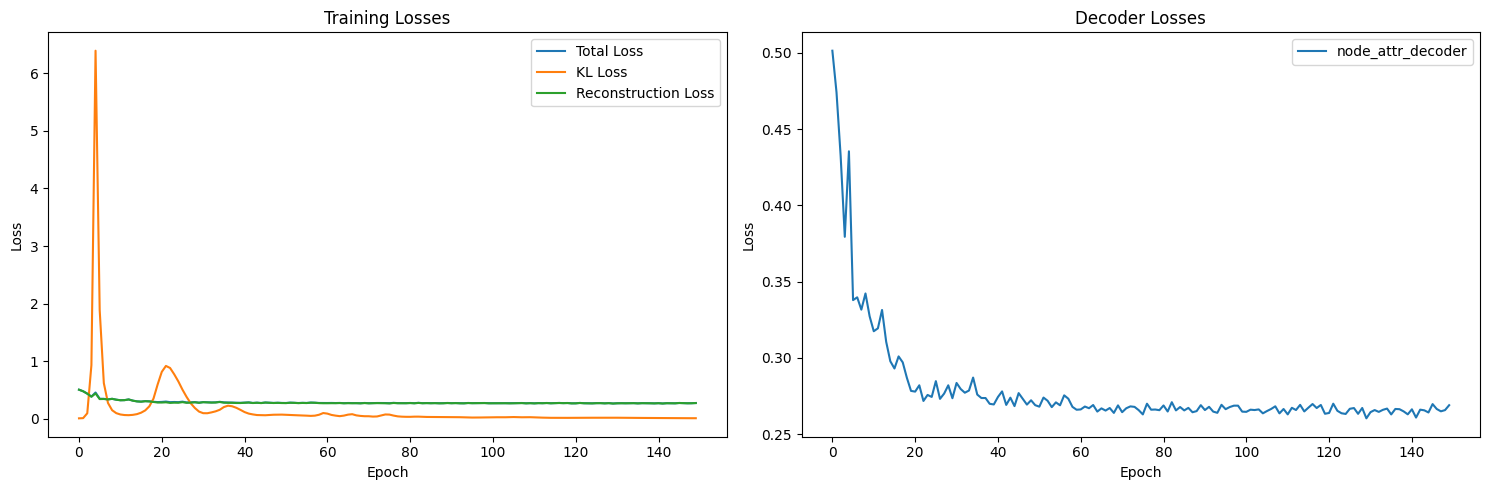

Adjacency decoder not found


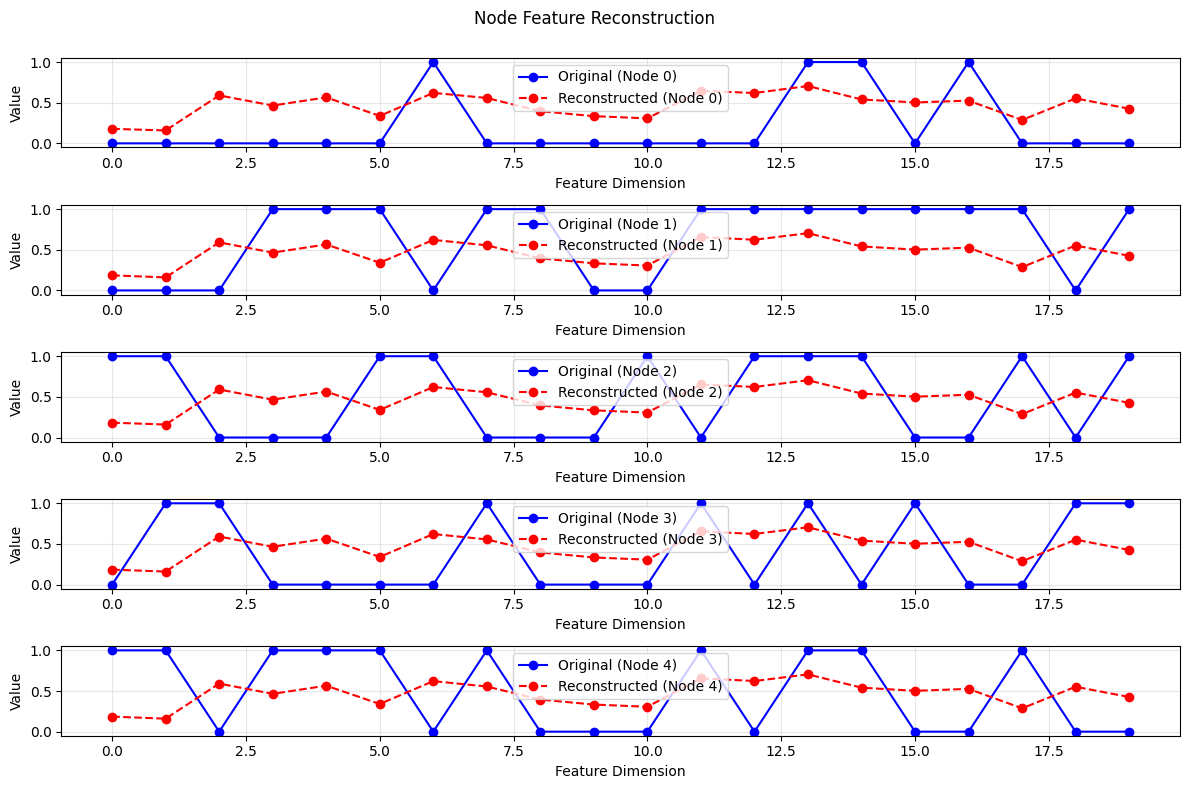

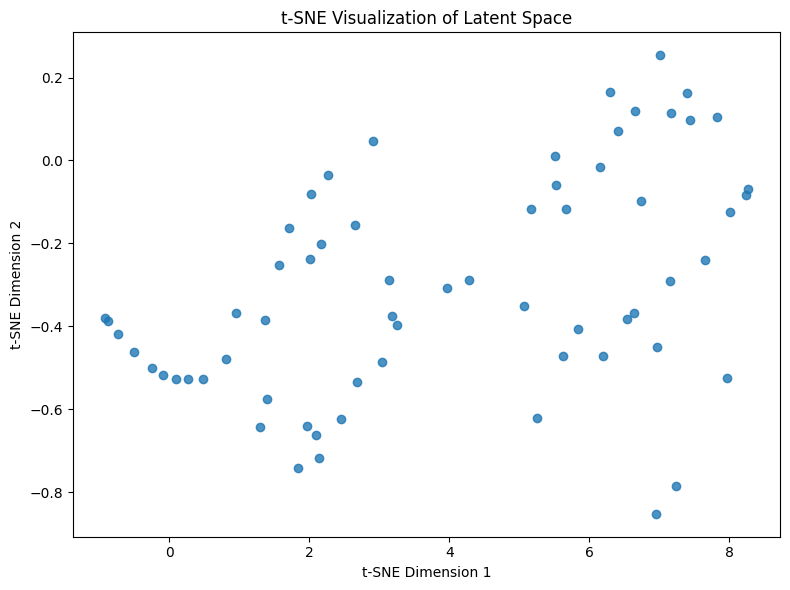

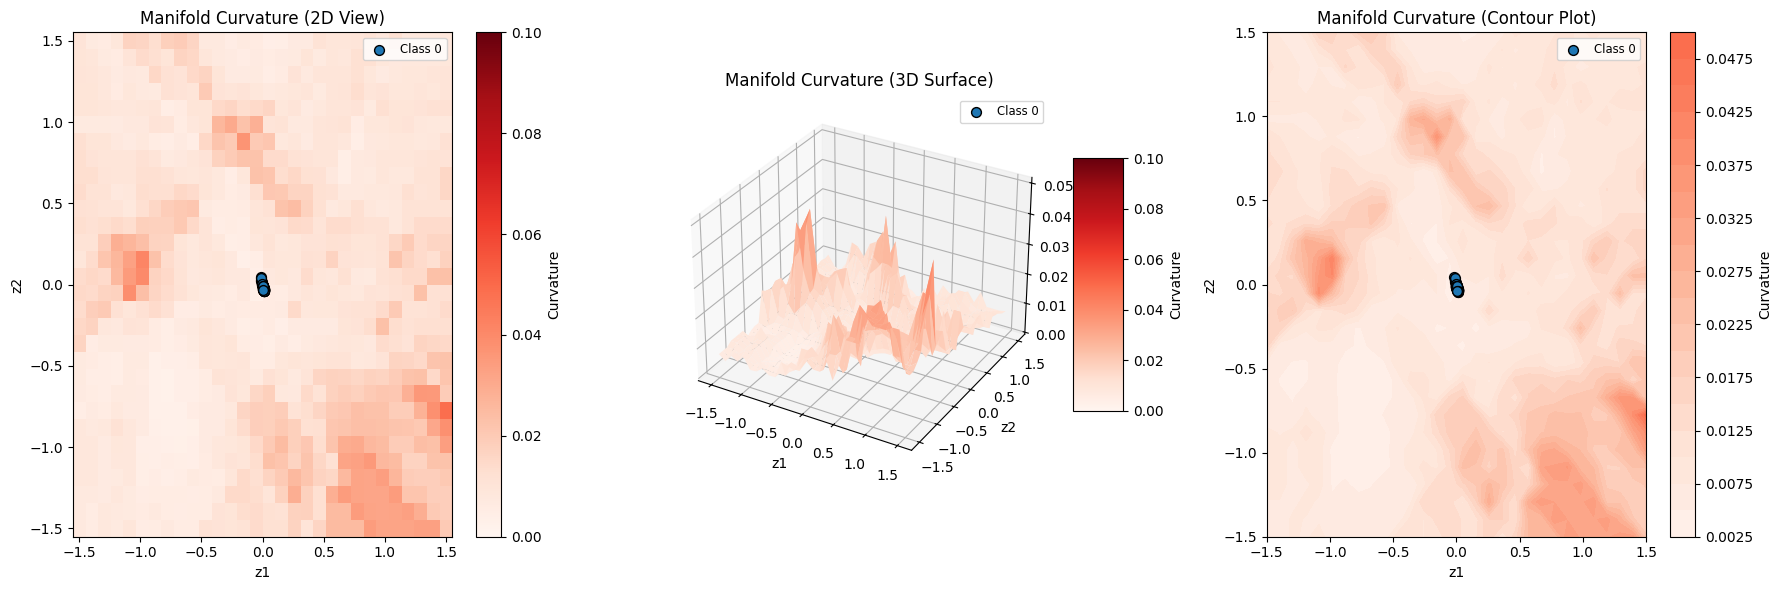

=== Starting Phase 2: Freezing encoder and adding adjacency decoder ===

=== Phase 2 Complete ===


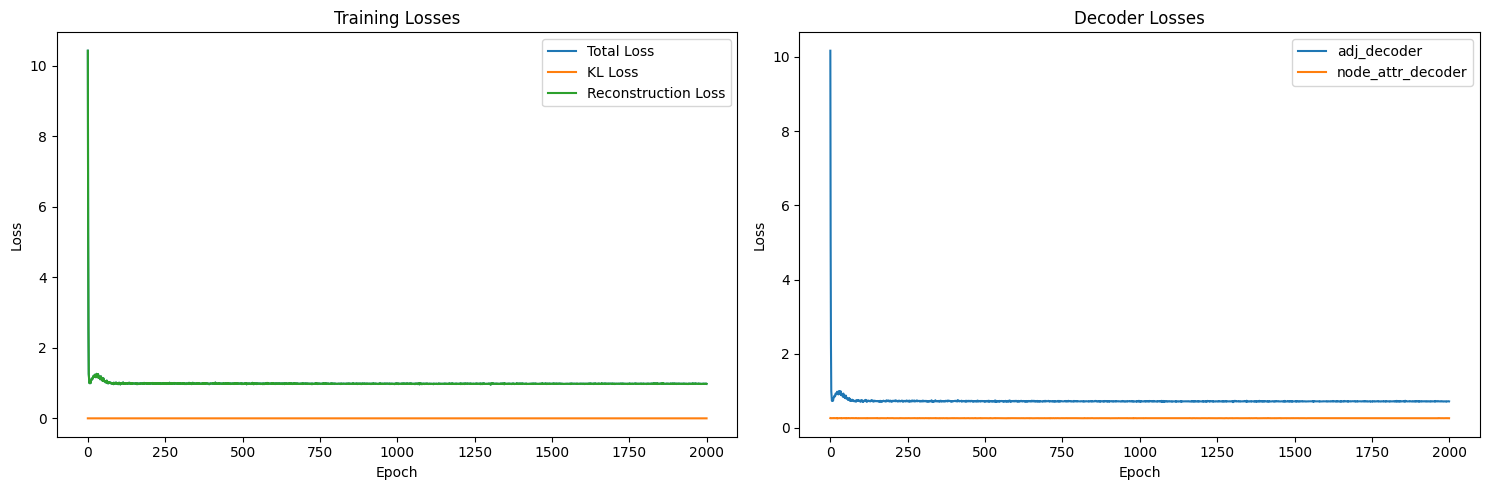

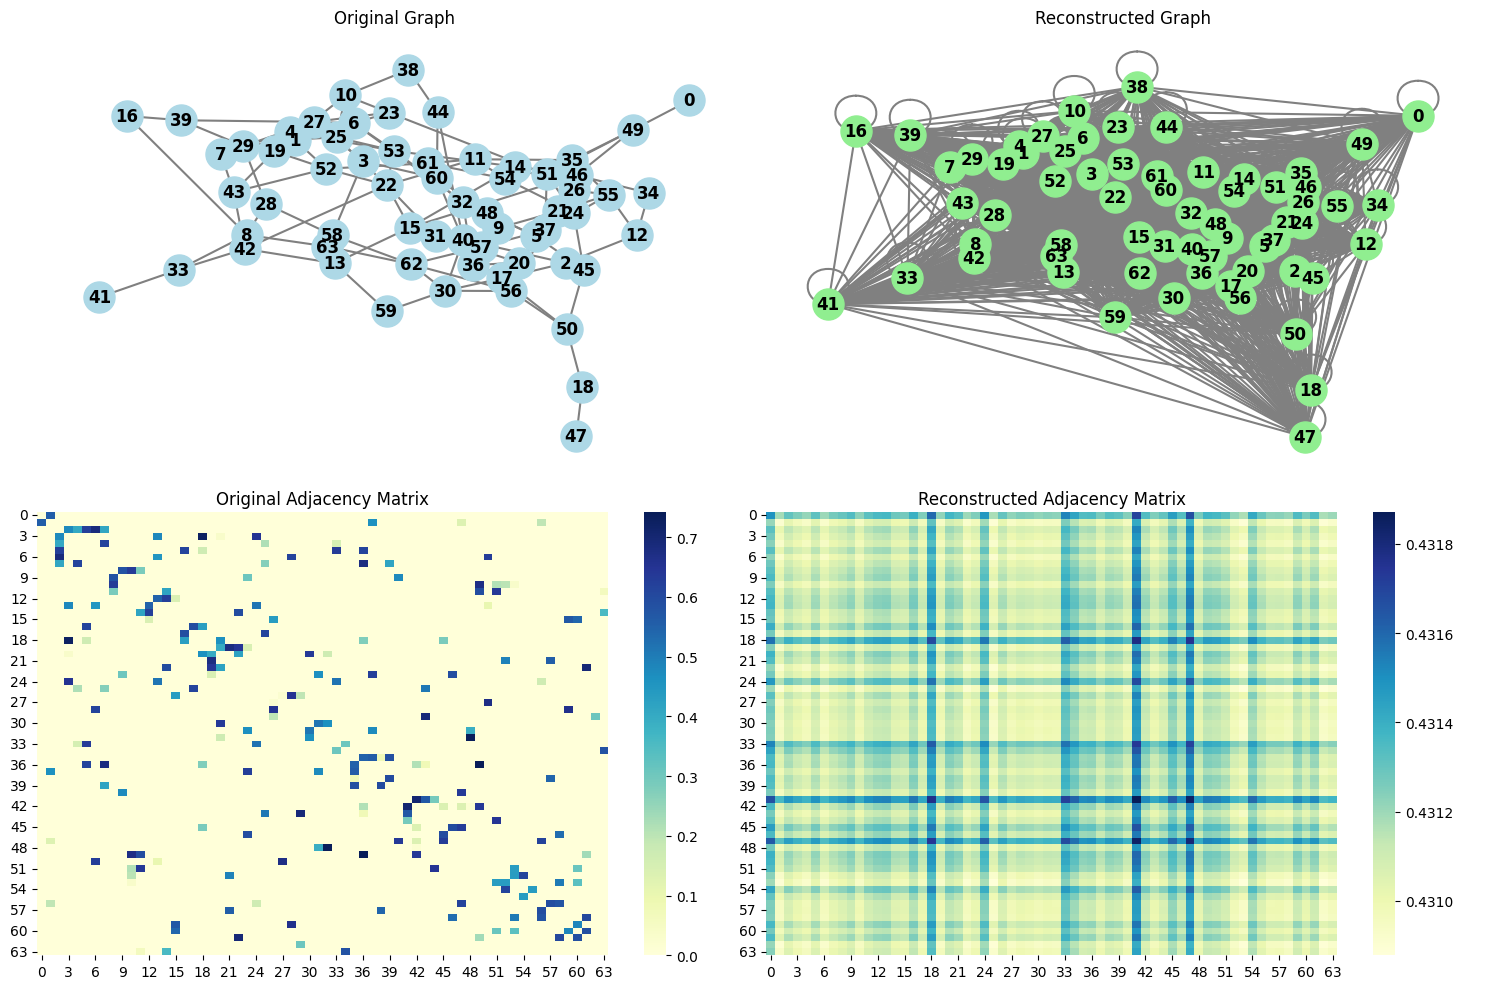

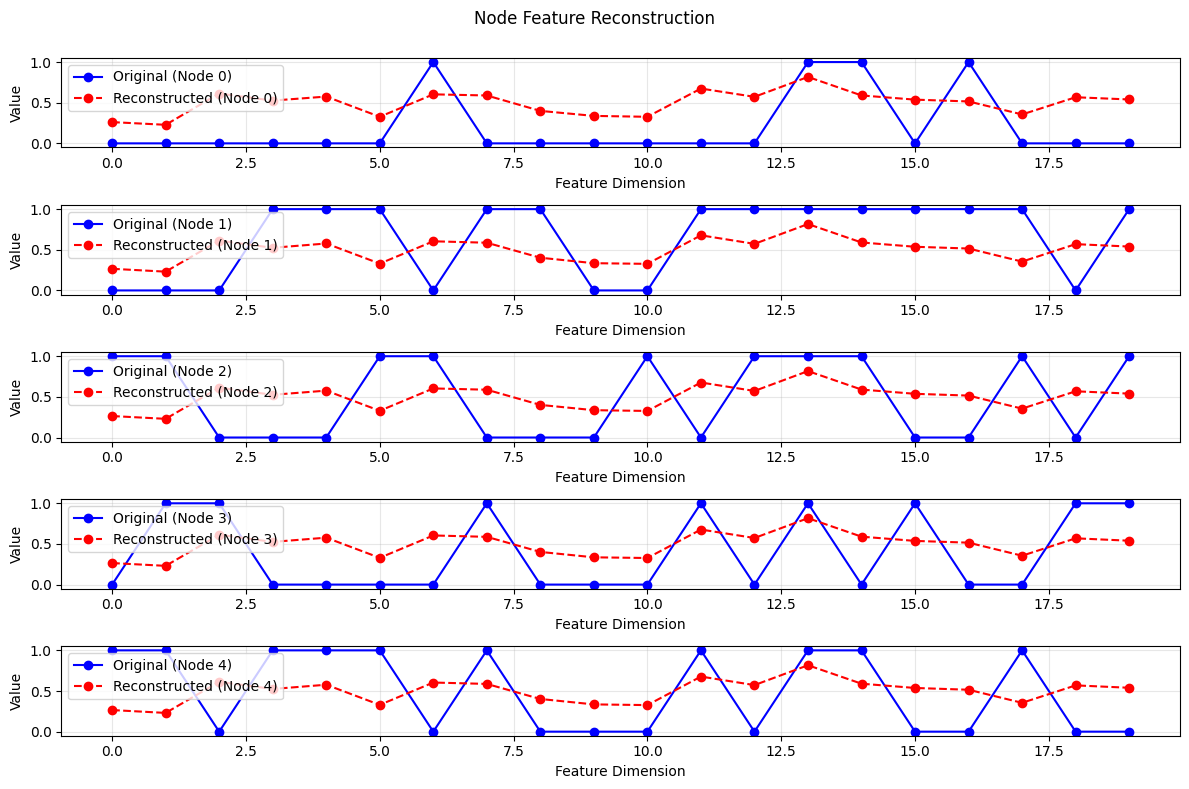

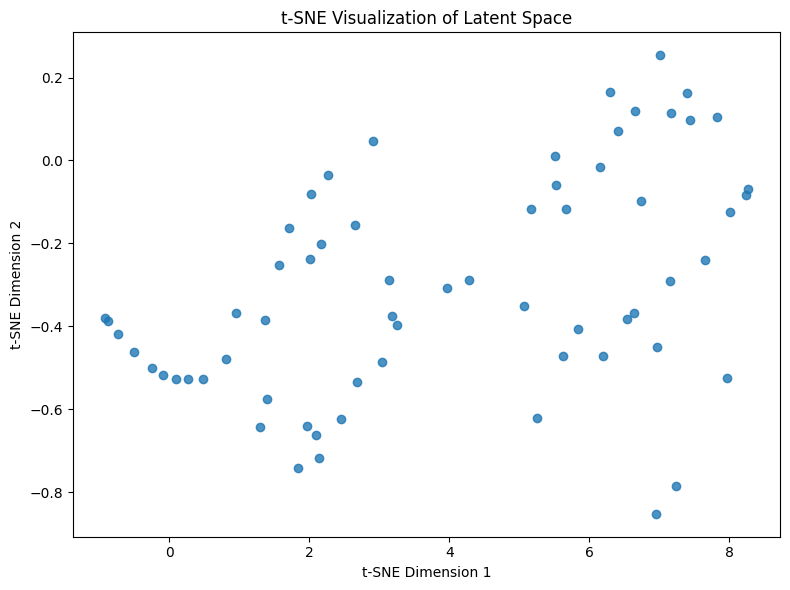

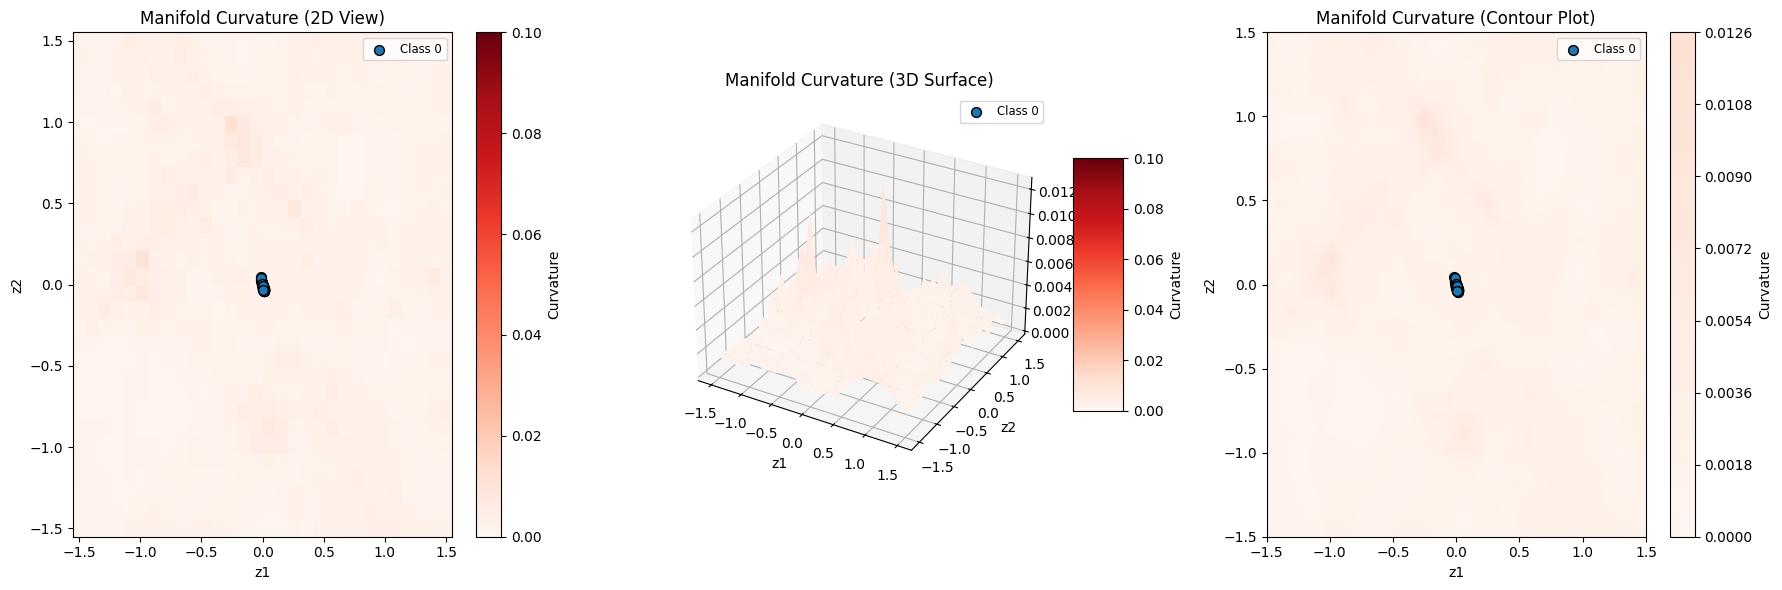

In [99]:
from framework.trainFct import two_phase_training

dropout = 0
phase1_epochs = 150
phase2_epochs = 2000
lr_phase1 = 0.001
lr_phase2 = 0.0001
latent_dim = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

# Run two-phase training
# model, history = two_phase_training(
#     input_dim=input_dim,
#     latent_dim=latent_dim,
#     data_loader_phase1=single_graph_list,
#     data_loader_phase2=single_graph_list,
#     phase1_epochs=100,
#     phase2_epochs=100,
#     verbose=True
# )

# Step 1: Create encoder and node decoder for phase 1
encoder = Encoder(
    input_dim=input_dim,
    hidden_dims=[5000, 1280,640, 312],
    latent_dim=latent_dim,
    gcn_layers=4,
    fc_layers=2,
    dropout=dropout
)
# encoder = MLPEncoder(
#     input_dim=input_dim,
#     latent_dim=latent_dim,
#     hidden_dims=[5000, 1280,640, 320],
#     mlp_layers=3,
#     dropout=dropout
# )

node_decoder = NodeAttributeDecoder(
    latent_dim=latent_dim,
    output_dim=input_dim,
    #hidden_dims=[64, 128, 256],
    hidden_dims=[128],
    dropout=dropout
)

# Create KL annealing scheduler
kl_scheduler = KLAnnealingScheduler(
    anneal_start=0.0,
    anneal_end=0.1,
    anneal_steps=phase1_epochs * len(single_graph_list),
    anneal_type='linear'
)

# Create initial model with only node decoder
model_phase1 = GraphVAE(
    encoder=encoder,
    decoders=[node_decoder],
    kl_scheduler=kl_scheduler
)

print("=== Starting Phase 1: Training encoder with node feature reconstruction ===")

# Phase 1 training
history_phase1 = train_phase1(
    model=model_phase1,
    data_loader=single_graph_list,
    num_epochs=phase1_epochs,
    lr=lr_phase1,
    weight_decay=1e-5,
    verbose=False,
    device=device,
    loss_coefficient=1
)

print("\n=== Phase 1 Complete ===")

visualize_training(history_phase1)
visualize_graph_reconstruction(model_phase1, single_graph)
visualize_node_features_reconstruction(model_phase1, single_graph, sample_features=dimP)
visualize_latent_space(model_phase1, [single_graph])
plot_curvature(model_phase1, single_graph)

print("=== Starting Phase 2: Freezing encoder and adding adjacency decoder ===")

# Step 2: Add adjacency decoder for phase 2
adjacency_decoder = AdjacencyDecoder(
    latent_dim=latent_dim,
    hidden_dims=[512, 1028, 1028, 1028, 512],
    activation=torch.nn.Tanh(),
    dropout=dropout
)

# Add adjacency decoder to model
model_phase1.add_decoder(adjacency_decoder)

# Reset KL scheduler for phase 2
model_phase1.kl_scheduler = KLAnnealingScheduler(
    anneal_start=0,  # Start at midpoint since encoder is already trained
    anneal_end=0.1,
    anneal_steps=phase2_epochs * len(single_graph_list),
    anneal_type='linear'
)

# Phase 2 training
history_phase2 = train_phase2(
    model=model_phase1,
    data_loader=single_graph_list,
    num_epochs=phase2_epochs,
    lr=lr_phase2,
    weight_decay=1e-5,
    decoder_weights={"adjacency_decoder": 1000, "node_decoder":2 },
    verbose=False,
    device=device
)

print("\n=== Phase 2 Complete ===")
visualize_training(history_phase2)
visualize_graph_reconstruction(model_phase1, single_graph)
visualize_node_features_reconstruction(model_phase1, single_graph, sample_features=dimP)
visualize_latent_space(model_phase1, [single_graph])
plot_curvature(model_phase1, single_graph)


# Combine histories
combined_history = {
    "phase1": history_phase1,
    "phase2": history_phase2
}

# Unfreeze encoder for potential further use
model_phase1.set_encoder_freeze(False)


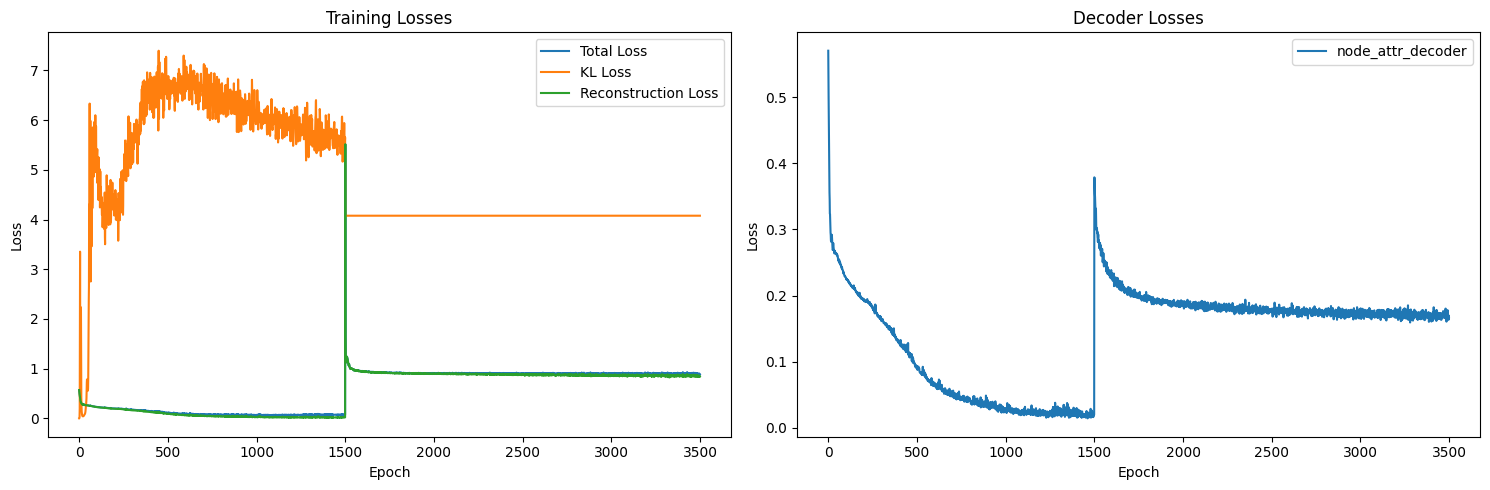

In [29]:
merged_history = {}
for key in history_phase1.keys():
  if isinstance(history_phase1[key], list):
    merged_history[key] = history_phase1[key] + history_phase2[key]
  else:
     merged_history[key] = dict()
     for key2 in history_phase1[key].keys():
        merged_history[key][key2] = history_phase1[key][key2] + history_phase2[key][key2]

visualize_training(merged_history)



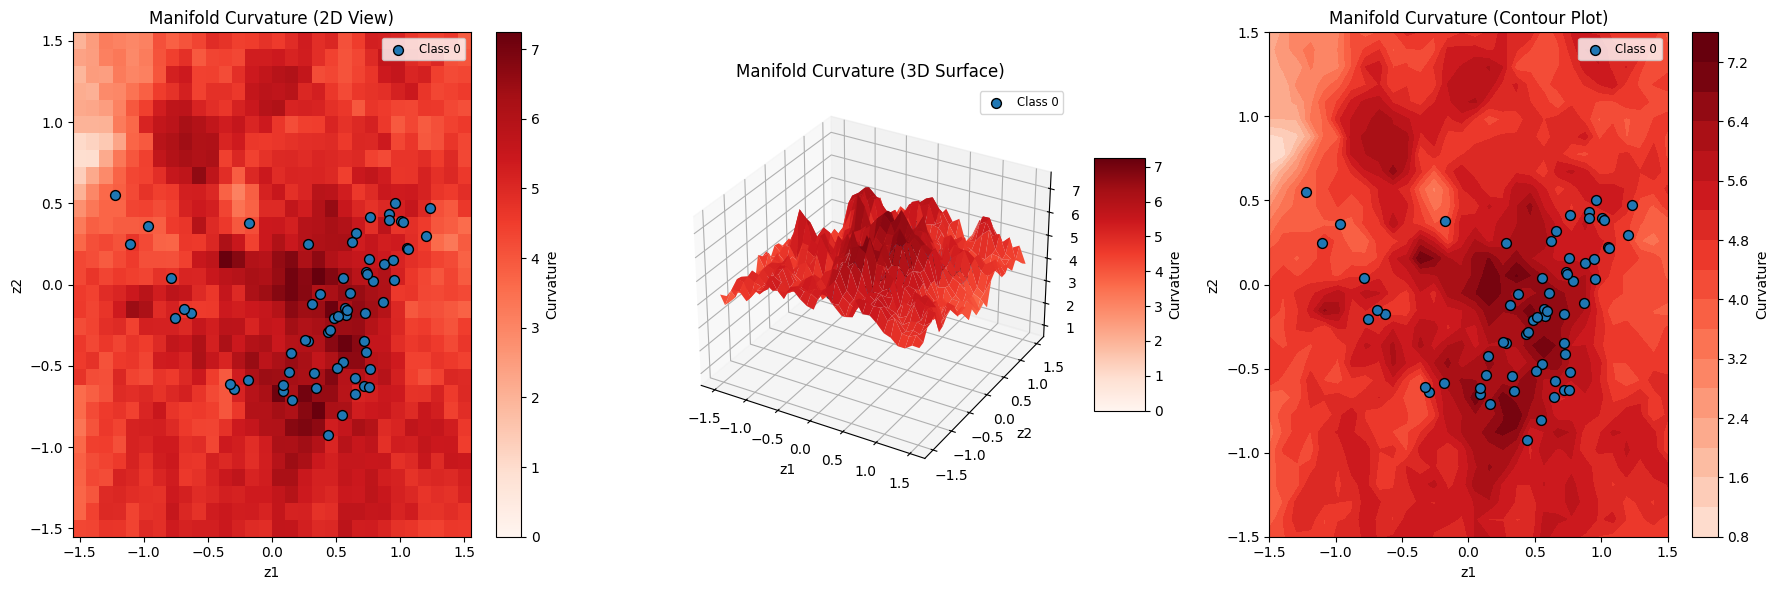

Error computing geodesic from [-1.25 -1.25] to [-1.25 -1.25]: list indices must be integers or slices, not tuple
Error computing geodesic from [-1.25  0.  ] to [-1.25  0.  ]: list indices must be integers or slices, not tuple
Error computing geodesic from [-1.25  1.25] to [-1.25  1.25]: list indices must be integers or slices, not tuple
Error computing geodesic from [-1.25  1.25] to [-1.25  1.25]: list indices must be integers or slices, not tuple
Error computing geodesic from [-1.25  1.25] to [-1.25  1.25]: list indices must be integers or slices, not tuple
Error computing geodesic from [0.   1.25] to [0.   1.25]: list indices must be integers or slices, not tuple
Error computing geodesic from [0.   1.25] to [0.   1.25]: list indices must be integers or slices, not tuple
Error computing geodesic from [0.   1.25] to [0.   1.25]: list indices must be integers or slices, not tuple
Error computing geodesic from [ 1.25 -1.25] to [ 1.25 -1.25]: list indices must be integers or slices, not t

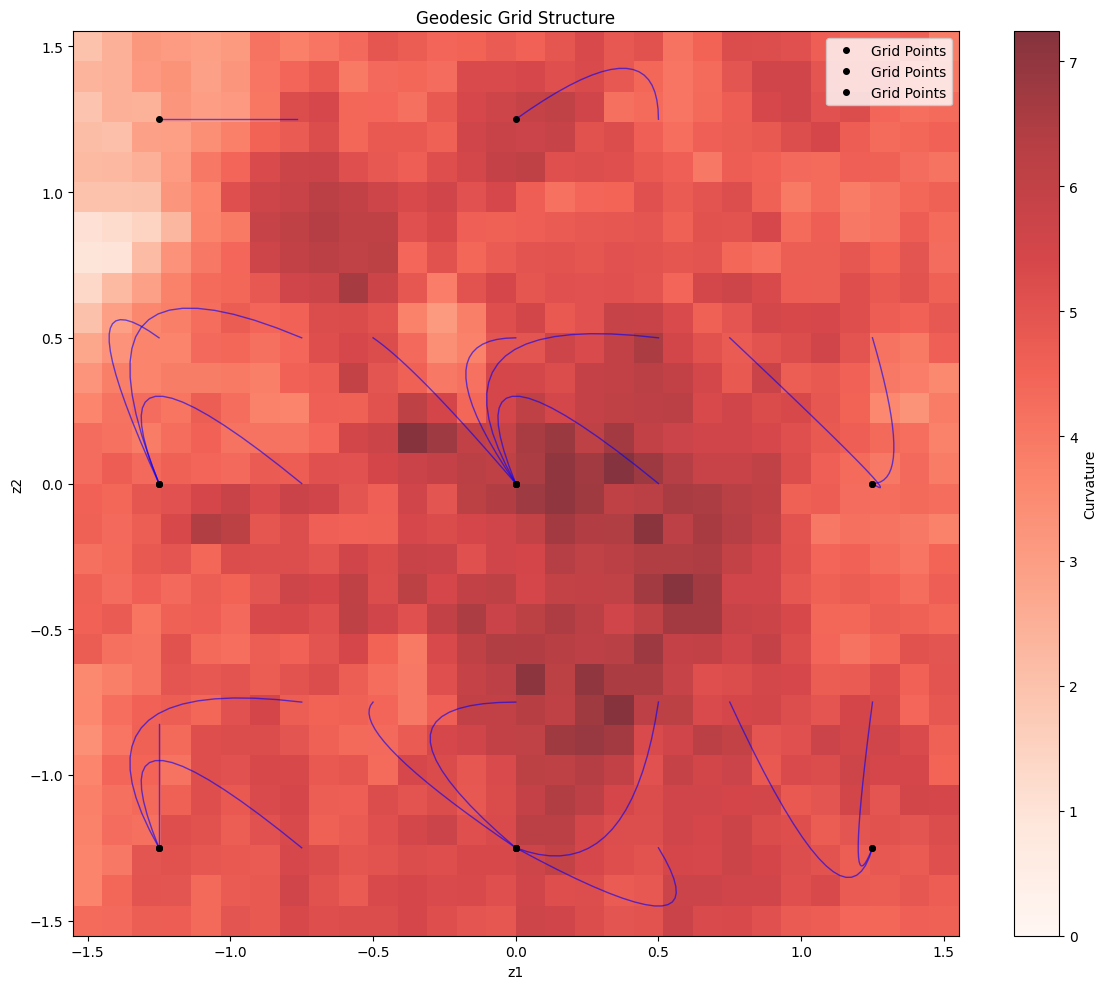